In [7]:
import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.gridspec import GridSpec
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import XMLFile
from selenobot.utils import seed 
from selenobot.datasets import Dataset, get_dataloader
from selenobot.utils import digitize, groupby, sample
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from tqdm import tqdm
from scipy.stats import false_discovery_control, mannwhitneyu

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
label_names = dict()
label_names[0] = 'full-length'
label_names[1] = 'truncated selenoprotein'
label_names[2] = 'short full-length'

label_colors = {1:'tab:red', 2:'tab:blue', 0:'tab:green'}

In [17]:
metadata_3c = dict()
metadata_3c['train'] = pd.read_csv('../data/3c_metadata_train.csv', index_col=0)
metadata_3c['test'] = pd.read_csv('../data/3c_metadata_test.csv', index_col=0)
metadata_3c['val'] = pd.read_csv('../data/3c_metadata_val.csv', index_col=0)

metadata_2c = dict()
metadata_2c['train'] = pd.read_csv('../data/3c_metadata_train.csv', index_col=0)
metadata_2c['test'] = pd.read_csv('../data/3c_metadata_test.csv', index_col=0)
metadata_2c['val'] = pd.read_csv('../data/3c_metadata_val.csv', index_col=0)

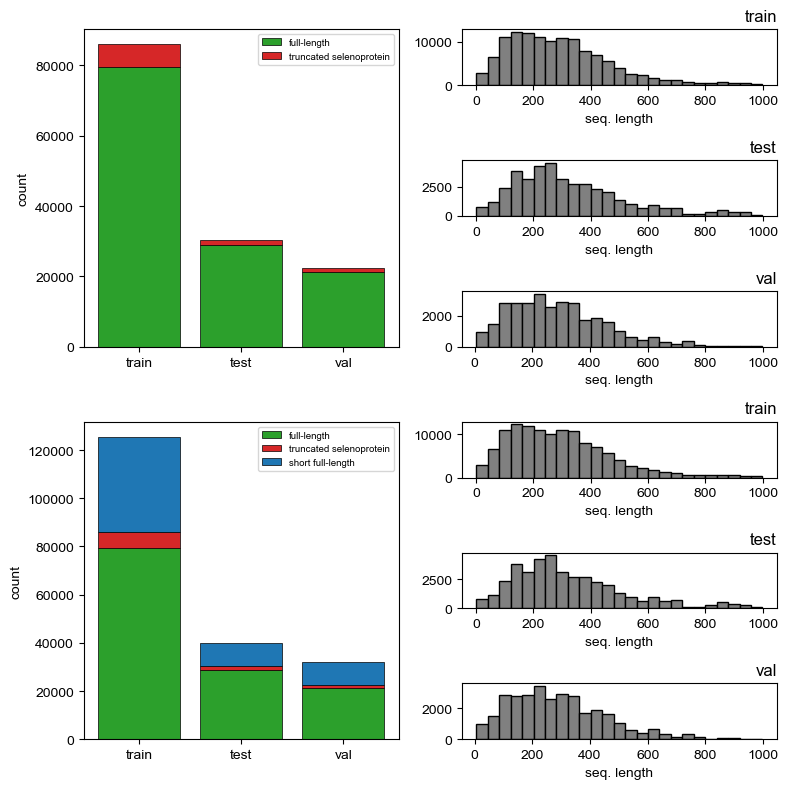

In [34]:
fig = plt.figure(layout='tight', figsize=(8, 8))
grid = GridSpec(6, 2, figure=fig)

datasets = ['train', 'test', 'val']

ax_1a = fig.add_subplot(grid[:3, 0])
ax_1b = [fig.add_subplot(grid[i, 1]) for i in range(0, 3)]
ax_1c = fig.add_subplot(grid[3:6, 0])
ax_1d = [fig.add_subplot(grid[i, 1]) for i in range(3, 6)]

labels = [0, 1]
positions = np.arange(3)
bottom = np.zeros(3)
for label in labels:
    heights = np.array([(metadata_2c[dataset]['label'] == label).sum() for dataset in datasets])
    ax_1a.bar(positions, heights, bottom=bottom, color=label_colors[label], edgecolor='black', lw=0.5)
    bottom += heights 

ax_1a.set_ylabel('count')
ax_1a.set_xticks(positions, datasets)
ax_1a.legend([label_names[label] for label in labels], loc='upper right', fontsize='x-small')

for ax, dataset in zip(ax_1b, datasets):
    ax.hist(metadata_2c[dataset].seq.apply(len), bins=25, lw=0.5, edgecolor='black', color='gray')
    ax.set_title(dataset, loc='right')
    # ax.set_ylabel('count')
    ax.set_xlabel('seq. length')


labels = [0, 1, 2]
positions = np.arange(3)
bottom = np.zeros(3)
for label in labels:
    heights = np.array([(metadata_3c[dataset]['label'] == label).sum() for dataset in datasets])
    ax_1c.bar(positions, heights, bottom=bottom, color=label_colors[label], edgecolor='black', lw=0.5)
    bottom += heights 

ax_1c.set_ylabel('count')
ax_1c.set_xticks(positions, datasets)
ax_1c.legend([label_names[label] for label in labels], loc='upper right', fontsize='x-small')


for ax, dataset in zip(ax_1d, datasets):
    ax.hist(metadata_3c[dataset].seq.apply(len), bins=25, lw=0.5, edgecolor='black', color='gray')
    ax.set_title(dataset, loc='right')
    # ax.set_ylabel('count')
    ax.set_xlabel('seq. length')

plt.show()


